In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score,roc_auc_score, plot_roc_curve, classification_report, plot_confusion_matrix
import seaborn as sn

In [71]:
tracts = pd.read_parquet('./data/tracts_joined.parquet')
lots = pd.read_parquet('./data/lots_joined.parquet')
all_lots = pd.read_parquet('./data/all_lots.parquet')
# lots_geo = gp.read_file('./input/lots_clean.geojson')
complaints = pd.read_parquet('./data/complaints_joined.parquet')

In [3]:
def binary_classification_performance(y_test, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_pred = y_pred, y_true = y_test),2)
    precision = round(precision_score(y_pred = y_pred, y_true = y_test),2)
    recall = round(recall_score(y_pred = y_pred, y_true = y_test),2)
    f1_score = round(2*precision*recall/(precision + recall),2)
    specificity = round(tn/(tn+fp),2)
    npv = round(tn/(tn+fn),2)
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),2)


    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'AUC_ROC' : [auc_roc],
                         'Specificty (or TNR)': [specificity],
                         'NPV' : [npv],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]})
    return result

In [27]:
complaints.dtypes

complaint_id                         int64
building_id                          int64
bbl                                 object
received_date               datetime64[ns]
status                              object
status_date                 datetime64[ns]
no_entry_problems                  float64
no_violation_problems              float64
violation_problems                 float64
problems                             int64
no_entry                             int64
violation                            int64
no_violation                         int64
built                              float64
res_area                           float64
units                              float64
value                              float64
total_area                         float64
latitude                           float64
longitude                          float64
value_per_sqft                     float64
sqft_per_unit                      float64
percent_bachelors                  float64
percent_hig

In [50]:
tracts.dtypes

percent_bachelors                   float64
percent_high_school                 float64
median_income                       float64
population                          float64
percent_white                       float64
percent_african_american            float64
percent_asian                       float64
percent_latino                      float64
percent_under_5                     float64
percent_5_to_9                      float64
boro                                 object
censustract                          object
borotract                            object
no_entry_complaints                 float64
no_violation_complaints             float64
violation_complaints                float64
complaints                          float64
violations                          float64
no_entry_problems                   float64
no_violation_problems               float64
violation_problems                  float64
res_area                            float64
units                           

In [32]:
features = ['built', 'res_area', 'units',
       'value', 'total_area', 'latitude', 'longitude',
       'value_per_sqft', 'sqft_per_unit', 'percent_bachelors', 'percent_high_school',
       'median_income', 'population', 'percent_white', 'percent_african_american',
       'percent_asian', 'percent_latino', 'percent_under_5', 'percent_5_to_9']

tract_features = ['complaints_per_unit','violation_complaints_per_unit','no_violation_complaints_per_unit','violations_per_unit','median_age','median_value_per_sqft','median_sqft_per_unit','percent_pre_1960']

In [33]:
completed = complaints[complaints.no_entry < 1]
completed = completed.merge(lots[['bbl','borotract']], on="bbl", how="left")
completed = completed.merge(tracts[['borotract']+tract_features], on="borotract", how="left")
completed = completed.dropna()
half_count = int(len(completed.borotract.unique()) * 0.5)
upper_half_tracts = completed.borotract.value_counts()[:half_count].index
upper_half_completed = completed[completed.borotract.isin(upper_half_tracts)]
print(len(completed))
print(len(upper_half_completed))
X = completed[features+tract_features]
y = completed['violation']

67104
61453


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=0)

In [35]:
rf_pl = Pipeline([
                  ('scaler', StandardScaler()),
                  ('rf',RandomForestClassifier(random_state=10))
])
param_grid = {
    'rf__n_estimators': [75, 90],
    'rf__max_depth': [20],
    'rf__max_features': ['auto',None],
    'rf__min_samples_leaf': [2]
}
rfc_grid = GridSearchCV(rf_pl, param_grid, cv=3, scoring='f1', verbose=2)
rfc_grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END rf__max_depth=20, rf__max_features=auto, rf__min_samples_leaf=2, rf__n_estimators=75; total time=   8.0s
[CV] END rf__max_depth=20, rf__max_features=auto, rf__min_samples_leaf=2, rf__n_estimators=75; total time=   7.9s
[CV] END rf__max_depth=20, rf__max_features=auto, rf__min_samples_leaf=2, rf__n_estimators=75; total time=   7.9s
[CV] END rf__max_depth=20, rf__max_features=auto, rf__min_samples_leaf=2, rf__n_estimators=90; total time=   9.5s
[CV] END rf__max_depth=20, rf__max_features=auto, rf__min_samples_leaf=2, rf__n_estimators=90; total time=   9.5s
[CV] END rf__max_depth=20, rf__max_features=auto, rf__min_samples_leaf=2, rf__n_estimators=90; total time=   9.5s
[CV] END rf__max_depth=20, rf__max_features=None, rf__min_samples_leaf=2, rf__n_estimators=75; total time=  34.5s
[CV] END rf__max_depth=20, rf__max_features=None, rf__min_samples_leaf=2, rf__n_estimators=75; total time=  35.7s
[CV] END rf__max_depth=20, r

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=10))]),
             param_grid={'rf__max_depth': [20],
                         'rf__max_features': ['auto', None],
                         'rf__min_samples_leaf': [2],
                         'rf__n_estimators': [75, 90]},
             scoring='f1', verbose=2)

In [36]:
rfc_best = rfc_grid.best_estimator_
y_pred = rfc_best.predict(X_test)
binary_classification_performance(y_test,y_pred)

,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.54,0.55,0.6,0.57,0.54,0.55,0.6,3096,4129,3427,2769


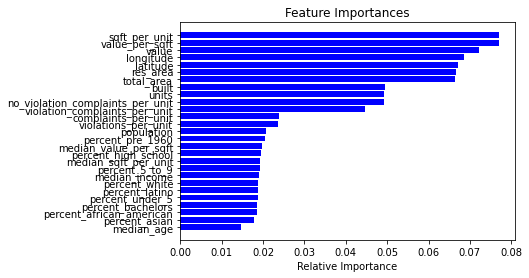

In [37]:
importances = rfc_best.named_steps['rf'].feature_importances_
indices = np.argsort(importances)
all_features = features+tract_features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [38]:
len(completed[completed.violation == 1])

34488

In [39]:
len(completed)

67104

In [55]:
features = ['built', 'res_area', 'units',
       'value', 'total_area', 'latitude', 'longitude',
       'value_per_sqft', 'sqft_per_unit', 'percent_bachelors', 'percent_high_school',
       'median_income', 'population', 'percent_white', 'percent_african_american',
       'percent_asian', 'percent_latino', 'percent_under_5', 'percent_5_to_9']

tract_features = ['median_age','median_value_per_sqft','median_sqft_per_unit','percent_pre_1960']

In [56]:
lots = lots.merge(tracts[['borotract']+tract_features], on="borotract", how="left")
lots = lots.dropna()
# half_count = int(len(completed.borotract.unique()) * 0.5)
# upper_half_tracts = completed.borotract.value_counts()[:half_count].index
# upper_half_completed = completed[completed.borotract.isin(upper_half_tracts)]
# print(len(completed))
# print(len(upper_half_completed))
X = lots[features+tract_features]
y = lots['has_violation']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=0)

In [58]:
rf_pl = Pipeline([
                  ('scaler', StandardScaler()),
                  ('rf',RandomForestClassifier(random_state=10))
])
param_grid = {
    'rf__n_estimators': [75, 90],
    'rf__max_depth': [20],
    'rf__max_features': ['auto',None],
    'rf__min_samples_leaf': [2]
}
rfc_grid = GridSearchCV(rf_pl, param_grid, cv=3, scoring='f1', verbose=2)
rfc_grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END rf__max_depth=20, rf__max_features=auto, rf__min_samples_leaf=2, rf__n_estimators=75; total time=  16.6s
[CV] END rf__max_depth=20, rf__max_features=auto, rf__min_samples_leaf=2, rf__n_estimators=75; total time=  17.9s
[CV] END rf__max_depth=20, rf__max_features=auto, rf__min_samples_leaf=2, rf__n_estimators=75; total time=  18.9s
[CV] END rf__max_depth=20, rf__max_features=auto, rf__min_samples_leaf=2, rf__n_estimators=90; total time=  20.5s
[CV] END rf__max_depth=20, rf__max_features=auto, rf__min_samples_leaf=2, rf__n_estimators=90; total time=  21.3s
[CV] END rf__max_depth=20, rf__max_features=auto, rf__min_samples_leaf=2, rf__n_estimators=90; total time=  21.3s
[CV] END rf__max_depth=20, rf__max_features=None, rf__min_samples_leaf=2, rf__n_estimators=75; total time= 1.5min
[CV] END rf__max_depth=20, rf__max_features=None, rf__min_samples_leaf=2, rf__n_estimators=75; total time= 1.4min
[CV] END rf__max_depth=20, r

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=10))]),
             param_grid={'rf__max_depth': [20],
                         'rf__max_features': ['auto', None],
                         'rf__min_samples_leaf': [2],
                         'rf__n_estimators': [75, 90]},
             scoring='f1', verbose=2)

In [59]:
rfc_best = rfc_grid.best_estimator_
y_pred = rfc_best.predict(X_test)
binary_classification_performance(y_test,y_pred)

,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.89,0.66,0.41,0.51,0.69,0.66,0.41,26168,1733,886,2485


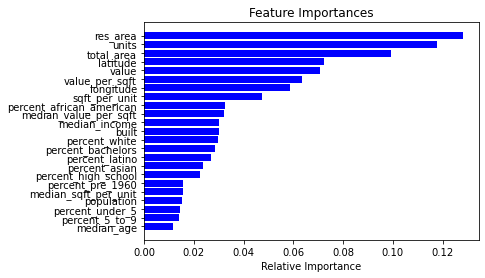

In [60]:
importances = rfc_best.named_steps['rf'].feature_importances_
indices = np.argsort(importances)
all_features = features+tract_features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

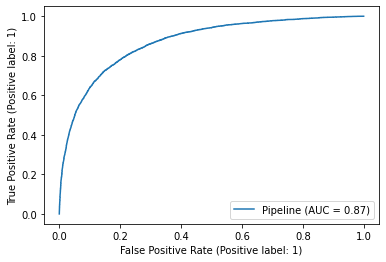

In [62]:
plot_roc_curve(rfc_best, X_test, y_test)

## Complaint Classification

In [154]:
features = ['built', 'res_area', 'units',
       'value', 'total_area', 'latitude', 'longitude',
       'value_per_sqft', 'sqft_per_unit', 'percent_bachelors', 'percent_high_school',
       'median_income', 'population', 'percent_white', 'percent_african_american',
       'percent_asian', 'percent_latino', 'percent_under_5', 'percent_5_to_9']

# lot_features = ['complaints_per_unit','violation_complaints_per_unit','no_violation_complaints_per_unit','violations_per_unit','median_value_per_sqft', 'median_sqft_per_unit','pre_1960_units_per_lot','percent_pre_1960',]
lot_features = ['median_value_per_sqft', 'median_sqft_per_unit','pre_1960_units_per_lot','percent_pre_1960',]

In [111]:
print(len(completed[completed.violation == 1]))
print(len(completed[completed.no_violation == 1]))

34488
32616


In [155]:
completed = complaints[complaints.no_entry < 1]
completed = completed.merge(lots[['bbl','borotract']], on="bbl", how="left")
completed = completed.merge(tracts[['borotract']+lot_features], on="borotract", how="left")
completed = completed.dropna()
upper_half_tracts = completed.borotract.value_counts()[:1467].index
upper_half_completed = completed[completed.borotract.isin(upper_half_tracts)]
print(len(completed))
print(len(upper_half_completed))
X = completed[features+lot_features]
y = completed['violation']

67104
66918


In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=completed['violation'], test_size = 0.4, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=0)
rf_pl = Pipeline([
                  ('scaler', StandardScaler()),
                  ('rf',RandomForestClassifier(random_state=10))
])
param_grid = {
    'rf__n_estimators': [10,50,100,250,500],
    'rf__max_depth': [2,4,8,16,32,None],
    'rf__max_features': ['auto','sqrt'],
    'rf__min_samples_split': [5,25,50,100]
}
# param_grid = {
#     'rf__n_estimators': [100],
#     'rf__max_depth': [2,10,None],
#     'rf__max_features': ['auto','sqrt'],
#     'rf__min_samples_leaf': [10,100,250]
# }
# param_grid = {
#     'rf__n_estimators': [250],
#     'rf__max_depth': [2],
#     'rf__max_features': ['auto'],
#     'rf__min_samples_split': [2]
# }
rfc_grid = GridSearchCV(rf_pl, param_grid, cv=3, scoring='f1', verbose=2)
rfc_grid.fit(X_train, y_train)
print(rfc_grid.best_params_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] END rf__max_depth=2, rf__max_features=auto, rf__min_samples_split=5, rf__n_estimators=10; total time=   0.2s
[CV] END rf__max_depth=2, rf__max_features=auto, rf__min_samples_split=5, rf__n_estimators=10; total time=   0.2s
[CV] END rf__max_depth=2, rf__max_features=auto, rf__min_samples_split=5, rf__n_estimators=10; total time=   0.2s
[CV] END rf__max_depth=2, rf__max_features=auto, rf__min_samples_split=5, rf__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=2, rf__max_features=auto, rf__min_samples_split=5, rf__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=2, rf__max_features=auto, rf__min_samples_split=5, rf__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=2, rf__max_features=auto, rf__min_samples_split=5, rf__n_estimators=100; total time=   1.3s
[CV] END rf__max_depth=2, rf__max_features=auto, rf__min_samples_split=5, rf__n_estimators=100; total time=   1.3s
[CV] END rf__max_depth=

In [160]:
rfc_best = rfc_grid.best_estimator_
y_pred = rfc_best.predict(X_test)
binary_classification_performance(y_test,y_pred)


,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.52,0.52,0.97,0.68,0.51,0.52,0.97,610,13316,12437,479


In [107]:
# ORIGINAL
rfc_best = rfc_grid.best_estimator_
y_pred = rfc_best.predict(X_test)
binary_classification_performance(y_test,y_pred)

,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.52,0.52,0.96,0.67,0.51,0.52,0.96,390,6632,6133,266


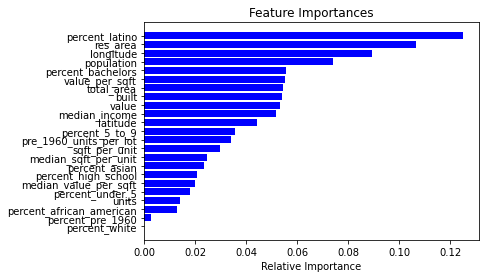

In [161]:
importances = rfc_best.named_steps['rf'].feature_importances_
indices = np.argsort(importances)
all_features = features+lot_features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

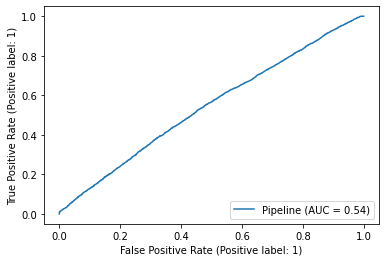

In [110]:
plot_roc_curve(rfc_best, X_test, y_test)

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=completed['violation'], test_size = 0.4, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=0)
bc_pl = Pipeline([
                  ('scaler', StandardScaler()),
                  ('bc',BaggingClassifier(random_state=10))
])
# param_grid = {
#     'rf__n_estimators': [5,10,50,100,250],
#     'rf__max_depth': [2,4,8,16,32,None],
#     'rf__max_features': ['auto',None],
#     'rf__min_samples_leaf': [3,5,10]
# }
param_grid = {
    'bc__base_estimator': [rfc_best.named_steps['rf']],
    'bc__n_estimators': [100],
    # 'bc__max_depth': [None],
    'bc__max_features': [1,5,10],
    # 'bc__min_samples_leaf': [500,1000]
}
bc_pl = GridSearchCV(bc_pl, param_grid, cv=3, scoring='f1', verbose=2)
bc_pl.fit(X_train, y_train)
print(bc_pl.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END bc__base_estimator=RandomForestClassifier(max_depth=2, min_samples_split=5, n_estimators=50,
                       random_state=10), bc__max_features=1, bc__n_estimators=100; total time=  36.8s
[CV] END bc__base_estimator=RandomForestClassifier(max_depth=2, min_samples_split=5, n_estimators=50,
                       random_state=10), bc__max_features=1, bc__n_estimators=100; total time=  32.3s
[CV] END bc__base_estimator=RandomForestClassifier(max_depth=2, min_samples_split=5, n_estimators=50,
                       random_state=10), bc__max_features=1, bc__n_estimators=100; total time=  32.3s
[CV] END bc__base_estimator=RandomForestClassifier(max_depth=2, min_samples_split=5, n_estimators=50,
                       random_state=10), bc__max_features=5, bc__n_estimators=100; total time=  37.0s
[CV] END bc__base_estimator=RandomForestClassifier(max_depth=2, min_samples_split=5, n_estimators=50,
                       

In [163]:
bc_best = bc_pl.best_estimator_
y_pred = bc_best.predict(X_test)
binary_classification_performance(y_test,y_pred)

,Accuracy,Precision (or PPV),Recall (senitivity or TPR),f1 score,AUC_ROC,Specificty (or TNR),NPV,True Positive,True Negative,False Positive,False Negative
0,0.52,0.52,1.0,0.68,0.5,0.52,1.0,77,13783,12970,12


## Tract level violation and complaint rate Regression Modeling

In [85]:
features = ['percent_bachelors', 'percent_high_school', 'median_income',
       'population', 'percent_white', 'percent_african_american',
       'percent_asian', 'percent_latino', 'percent_under_5', 'percent_5_to_9', 
        'percent_lot_pre_1960', 'pre_1960_units_per_lot',
       'all_units_per_lot', 'percent_pre_1960',
       'median_age', 'median_value_per_sqft', 'median_sqft_per_unit']

target_features = ['complaints_per_unit', 'violations_per_unit',
       'no_entry_complaints_per_unit', 'no_violation_complaints_per_unit',
       'violation_complaints_per_unit', 'violation_problems_per_unit',
       'no_entry_problems_per_unit', 'no_violation_problems_per_unit','no_entry_complaints',
       'no_violation_complaints', 'violation_complaints', 'complaints',
       'violations', 'no_entry_problems', 'no_violation_problems',
       'violation_problems',]

0.3969096764977921


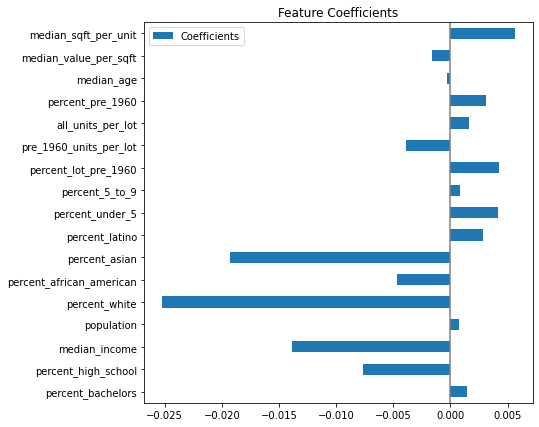

In [103]:
X = tracts.dropna()[features]
y = tracts.dropna()['violations_per_unit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
pipeline = Pipeline([
    ('ss', StandardScaler()), 
    ('logreg', LinearRegression())
])
pipeline.fit(X_train, y_train)
print(pipeline.score(X_test, y_test))
coefs = pd.DataFrame(
    pipeline.named_steps['logreg'].coef_,
    columns=['Coefficients'], index=X.columns
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Coefficients')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

0.3743882550875529


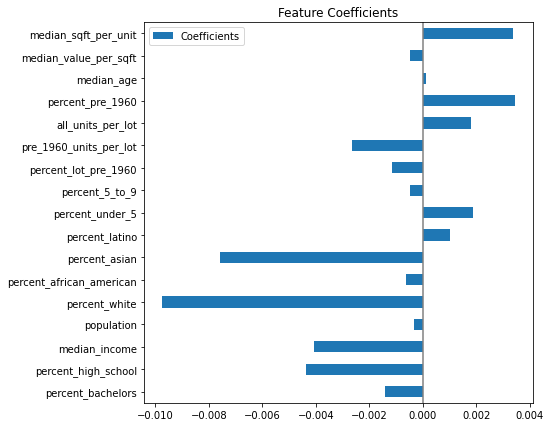

In [101]:
X = tracts.dropna()[features]
y = tracts.dropna()['violation_complaints_per_unit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
pipeline = Pipeline([
    ('ss', StandardScaler()), 
    ('logreg', LinearRegression())
])
pipeline.fit(X_train, y_train)
print(pipeline.score(X_test, y_test)
coefs = pd.DataFrame(
    pipeline.named_steps['logreg'].coef_,
    columns=['Coefficients'], index=X.columns
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Coefficients')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

0.20679401595847602


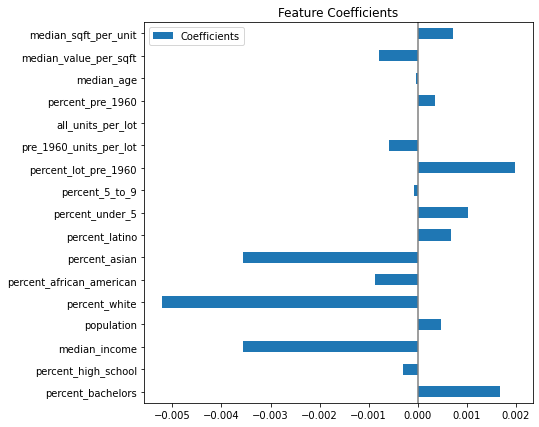

In [93]:
X = tracts.dropna()[features]
y = tracts.dropna()['no_entry_complaints_per_unit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
pipeline = Pipeline([
    ('ss', StandardScaler()), 
    ('logreg', LinearRegression())
])
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)
coefs = pd.DataFrame(
    pipeline.named_steps['logreg'].coef_,
    columns=['Coefficients'], index=X.columns
)
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Coefficients')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)